<a href="https://colab.research.google.com/github/VitalyGladyshev/med_work/blob/main/HD_HW_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование и диагностика в медицине с помощью машинного обучения

## ДЗ 3 Гладышев В.В.

## Regensburg Pediatric Appendicitis

### Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import KBinsDiscretizer

import math

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
!pip install ucimlrepo

In [2]:
RANDOM_STATE = 42

In [3]:
from ucimlrepo import fetch_ucirepo

In [17]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00


In [4]:
import catboost

In [5]:
import tensorflow as tf

In [108]:
# from keras.src import ops
# from keras.src.api_export import keras_export
# from keras.src.callbacks.callback import Callback
# from keras.src.trainers import compile_utils
# from keras.src.utils import io_utils

In [6]:
def classification_metrics(y, pred):
    pre = accuracy_score(y, pred)
    print(f"accuracy score:\t\t{pre:.5f}\n")

    pre = f1_score(y, pred, average="macro")
    print(f"f1 score:\t\t{pre:.5f}")

    pre = precision_score(y, pred, average="macro")
    print(f"precision score:\t{pre:.5f}")

    pre = recall_score(y, pred, average="macro", zero_division=0.0)
    print(f"recall score:\t\t{pre:.5f}")

### Загрузка и подготовка данных

In [7]:
# fetch dataset
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)

# data (as pandas dataframes)
X = regensburg_pediatric_appendicitis.data.features
y = regensburg_pediatric_appendicitis.data.targets

# metadata
print(regensburg_pediatric_appendicitis.metadata)

# variable information
print(regensburg_pediatric_appendicitis.variables)

{'uci_id': 938, 'name': 'Regensburg Pediatric Appendicitis', 'repository_url': 'https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis', 'data_url': 'https://archive.ics.uci.edu/static/public/938/data.csv', 'abstract': 'This repository holds the data from a cohort of pediatric patients with suspected appendicitis admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany, between 2016 and 2021. Each patient has (potentially multiple) ultrasound (US) images, aka views, tabular data comprising laboratory, physical examination, scoring results and ultrasonographic findings extracted manually by the experts, and three target variables, namely, diagnosis, management and severity.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Image'], 'num_instances': 782, 'num_features': 53, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': ['Age', 'Sex'], 'target_col': ['Management', 'Severity',

In [8]:
df = pd.concat([X, y], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contrala

In [10]:
df.isna().sum()

,0
Age,1
BMI,27
Sex,2
Height,26
Weight,3
Length_of_Stay,4
Alvarado_Score,52
Paedriatic_Appendicitis_Score,52
Appendix_on_US,5
Appendix_Diameter,284


In [11]:
null = df.isna().sum() / len(df) * 100
null = pd.DataFrame({'feature':null.index, 'null_percentage':null}) \
                    .sort_values(by='null_percentage', ascending=False) \
                    .reset_index(drop=True)
null.head(30)

,feature,null_percentage
0,Abscess_Location,98.337596
1,Gynecological_Findings,96.675192
2,Conglomerate_of_Bowel_Loops,94.501279
3,Segmented_Neutrophils,93.094629
4,Ileus,92.327366
5,Perfusion,91.943734
6,Enteritis,91.560102
7,Appendicolith,91.176471
8,Coprostasis,90.920716
9,Perforation,89.641944


In [12]:
print(regensburg_pediatric_appendicitis.variables)

                                name     role         type demographic  \
0                                Age  Feature   Continuous         Age   
1                                BMI  Feature   Continuous        None   
2                                Sex  Feature  Categorical         Sex   
3                             Height  Feature   Continuous        None   
4                             Weight  Feature      Integer        None   
5                     Length_of_Stay  Feature      Integer        None   
6                         Management   Target  Categorical        None   
7                           Severity   Target  Categorical        None   
8              Diagnosis_Presumptive    Other       Binary        None   
9                          Diagnosis   Target       Binary        None   
10                    Alvarado_Score  Feature      Integer        None   
11     Paedriatic_Appendicitis_Score  Feature      Integer        None   
12                    Appendix_on_US  

Удаляем признаки где процент пропусков больше 65%

In [13]:
df_cols = df.columns
drop_cols = []
for col in df_cols:
    if ((df[col].isna().sum()/len(df) )*100) > 65:
      drop_cols.append(col)
drop_cols

['Segmented_Neutrophils',
 'Appendix_Wall_Layers',
 'Target_Sign',
 'Appendicolith',
 'Perfusion',
 'Perforation',
 'Surrounding_Tissue_Reaction',
 'Appendicular_Abscess',
 'Abscess_Location',
 'Pathological_Lymph_Nodes',
 'Lymph_Nodes_Location',
 'Bowel_Wall_Thickening',
 'Conglomerate_of_Bowel_Loops',
 'Ileus',
 'Coprostasis',
 'Meteorism',
 'Enteritis',
 'Gynecological_Findings']

In [14]:
len(drop_cols)

18

In [15]:
df = df.drop (drop_cols, axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contrala

In [16]:
df.Diagnosis.value_counts()

,count
Diagnosis,
appendicitis,463
no appendicitis,317


Заполним пропуски в диаметре аппендикса 0 если человек был здоров, если же болен - то средним значением.

Все остальные пропуски заполняем средним соответствующим своей группе по таргету - если это числовой, модой тоже по такому принципу - если это категориальный.

In [17]:
df.query("Diagnosis =='no appendicitis'")['Appendix_Diameter'].describe()

,Appendix_Diameter
count,127.000000
mean,5.037008
std,1.171541
min,2.700000
25%,4.000000
50%,5.000000
75%,5.500000
max,9.500000


Убираем напрямую коррелирующий признаки - диаметр аппендицита и PAS

In [18]:
df = df.drop (['Appendix_Diameter', 'Paedriatic_Appendicitis_Score' ], axis = 1)

In [19]:
df = df.drop (['Management', 'Severity' ], axis = 1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Appendix_on_US                    777 non-null    object 
 8   Migratory_Pain                    773 non-null    object 
 9   Lower_Right_Abd_Pain              774 non-null    object 
 10  Contralateral_Rebound_Tenderness  767 non-null    object 
 11  Coughing_Pain                     766 non-null    object 
 12  Nausea  

In [21]:
df.BMI.mean()

18.907012426874175

In [22]:
df.Sex.unique()

array(['female', 'male', nan], dtype=object)

In [23]:
numbers_list = df.select_dtypes(include=['float64']).columns.tolist()

In [24]:
for ft in numbers_list:
    mean_val = df[ft].mean()
    print(f"{ft} mean: {mean_val}")
    df.loc[df[ft].isna(), ft] = mean_val

Age mean: 11.346451074058898
BMI mean: 18.907012426874175
Height mean: 148.01746031746032
Weight mean: 43.17254172015405
Length_of_Stay mean: 4.284061696658098
Alvarado_Score mean: 5.921917808219178
Body_Temperature mean: 37.40451612903226
WBC_Count mean: 12.670682989690723
Neutrophil_Percentage mean: 71.79116347569955
RBC_Count mean: 4.799489528795812
Hemoglobin mean: 13.380497382198953
RDW mean: 13.180291005291004
Thrombocyte_Count mean: 285.2526178010471
CRP mean: 31.386900129701687


In [25]:
obj_list = df.select_dtypes(include=['object']).columns.tolist()

In [26]:
for ft in obj_list:
    print(f"{ft}: len: {len(df[ft].unique())} items: {df[ft].unique()}")

Sex: len: 3 items: ['female' 'male' nan]
Appendix_on_US: len: 3 items: ['yes' 'no' nan]
Migratory_Pain: len: 3 items: ['no' 'yes' nan]
Lower_Right_Abd_Pain: len: 3 items: ['yes' 'no' nan]
Contralateral_Rebound_Tenderness: len: 3 items: ['yes' 'no' nan]
Coughing_Pain: len: 3 items: ['no' 'yes' nan]
Nausea: len: 3 items: ['no' 'yes' nan]
Loss_of_Appetite: len: 3 items: ['yes' 'no' nan]
Neutrophilia: len: 3 items: ['no' 'yes' nan]
Ketones_in_Urine: len: 5 items: ['++' 'no' nan '+++' '+']
RBC_in_Urine: len: 5 items: ['+' 'no' nan '++' '+++']
WBC_in_Urine: len: 5 items: ['no' '+' nan '+++' '++']
Dysuria: len: 3 items: ['no' 'yes' nan]
Stool: len: 5 items: ['normal' 'constipation' 'diarrhea' nan 'constipation, diarrhea']
Peritonitis: len: 4 items: ['no' 'local' 'generalized' nan]
Psoas_Sign: len: 3 items: ['yes' 'no' nan]
Ipsilateral_Rebound_Tenderness: len: 3 items: ['no' 'yes' nan]
US_Performed: len: 3 items: ['yes' 'no' nan]
Free_Fluids: len: 3 items: ['no' 'yes' nan]
Diagnosis: len: 3 it

In [27]:
df.loc[df["Diagnosis"].isna()]

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,...,WBC_in_Urine,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,Free_Fluids,Diagnosis
428,11.346451,18.907012,NaN,148.01746,43.172542,4.284062,5.921918,NaN,NaN,NaN,...,NaN,31.3869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
535,14.950000,20.320000,female,163.00000,54.000000,3.000000,5.921918,NaN,NaN,NaN,...,NaN,31.3869,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN


In [28]:
df.loc[df["Diagnosis"].isna()].index

Index([428, 535], dtype='int64')

In [29]:
df.drop(df.loc[df["Diagnosis"].isna()].index, inplace=True)

In [30]:
for ft in obj_list:
    df.loc[df[ft].isna(), ft] = "nan"

In [31]:
for ft in obj_list:
    df[ft] = pd.factorize(df[ft])[0]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780 entries, 0 to 781
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               780 non-null    float64
 1   BMI                               780 non-null    float64
 2   Sex                               780 non-null    int64  
 3   Height                            780 non-null    float64
 4   Weight                            780 non-null    float64
 5   Length_of_Stay                    780 non-null    float64
 6   Alvarado_Score                    780 non-null    float64
 7   Appendix_on_US                    780 non-null    int64  
 8   Migratory_Pain                    780 non-null    int64  
 9   Lower_Right_Abd_Pain              780 non-null    int64  
 10  Contralateral_Rebound_Tenderness  780 non-null    int64  
 11  Coughing_Pain                     780 non-null    int64  
 12  Nausea       

In [33]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop('Diagnosis', axis=1), df['Diagnosis'], test_size=0.2, random_state=42)

## Классификаторы

### Catboost

In [108]:
# Создаем классификатор CatBoost
model_cat = catboost.CatBoostClassifier()

In [109]:
model_cat.fit(X_train, y_train)

Learning rate set to 0.008423
0:	learn: 0.6847400	total: 64.5ms	remaining: 1m 4s
1:	learn: 0.6775663	total: 72ms	remaining: 35.9s
2:	learn: 0.6698116	total: 83.3ms	remaining: 27.7s
3:	learn: 0.6614669	total: 92.3ms	remaining: 23s
4:	learn: 0.6561319	total: 94.9ms	remaining: 18.9s
5:	learn: 0.6497903	total: 104ms	remaining: 17.3s
6:	learn: 0.6440942	total: 111ms	remaining: 15.8s
7:	learn: 0.6376036	total: 120ms	remaining: 14.8s
8:	learn: 0.6304254	total: 128ms	remaining: 14.1s
9:	learn: 0.6252781	total: 134ms	remaining: 13.2s
10:	learn: 0.6199304	total: 139ms	remaining: 12.5s
11:	learn: 0.6134576	total: 148ms	remaining: 12.2s
12:	learn: 0.6065288	total: 155ms	remaining: 11.8s
13:	learn: 0.6010796	total: 164ms	remaining: 11.5s
14:	learn: 0.5940802	total: 179ms	remaining: 11.8s
15:	learn: 0.5895093	total: 184ms	remaining: 11.3s
16:	learn: 0.5834393	total: 192ms	remaining: 11.1s
17:	learn: 0.5784275	total: 200ms	remaining: 10.9s
18:	learn: 0.5729704	total: 206ms	remaining: 10.7s
19:	learn:

In [110]:
predict = model_cat.predict(X_test)

In [112]:
classification_metrics(y_test, predict)

accuracy score:		0.85897

f1 score:		0.85428
precision score:	0.85612
recall score:		0.85275


### RandomForestClassifier

In [102]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
classification_metrics(y_test, preds)

accuracy score:		0.85256

f1 score:		0.84566
precision score:	0.85450
recall score:		0.84066


### Support Vector Machine

In [103]:
svm_model = SVC(gamma="auto", random_state=RANDOM_STATE)
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_test)
classification_metrics(y_test, preds)

accuracy score:		0.58974

f1 score:		0.38507
precision score:	0.79355
recall score:		0.50769


### GradientBoostingClassifier

In [104]:
gb_classifier = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_classifier.fit(X_train, y_train)
preds = gb_classifier.predict(X_test)
classification_metrics(y_test, preds)

accuracy score:		0.85897

f1 score:		0.85278
precision score:	0.86004
recall score:		0.84835


### Keras

In [40]:
type(X_train.values), X_train.shape

(numpy.ndarray, (624, 33))

In [46]:
type(y_train.values)

numpy.ndarray

In [95]:
tf.random.set_seed(RANDOM_STATE)

norm_layer = tf.keras.layers.Normalization()
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
])

In [96]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [97]:
norm_layer.adapt(X_train.values)

In [98]:
X_train.values.shape, y_train.values.shape

((624, 33), (624,))

In [99]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [100]:
history = model.fit(X_train.values, y_train.values, epochs=50,
                    validation_data=(X_test.values, y_test.values), callbacks=[callback])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6022 - loss: 0.6743 - val_accuracy: 0.6026 - val_loss: 0.6452
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6547 - loss: 0.6245 - val_accuracy: 0.6474 - val_loss: 0.6053
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6965 - loss: 0.5871 - val_accuracy: 0.6859 - val_loss: 0.5707
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7585 - loss: 0.5551 - val_accuracy: 0.7244 - val_loss: 0.5403
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7901 - loss: 0.5271 - val_accuracy: 0.7628 - val_loss: 0.5140
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7942 - loss: 0.5022 - val_accuracy: 0.7821 - val_loss: 0.4912
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8029 - loss: 0.4802 - val_accuracy: 0.7885 - val_loss: 0.4716
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8215 - loss: 0.4608 - val_accuracy: 0.8013 - val

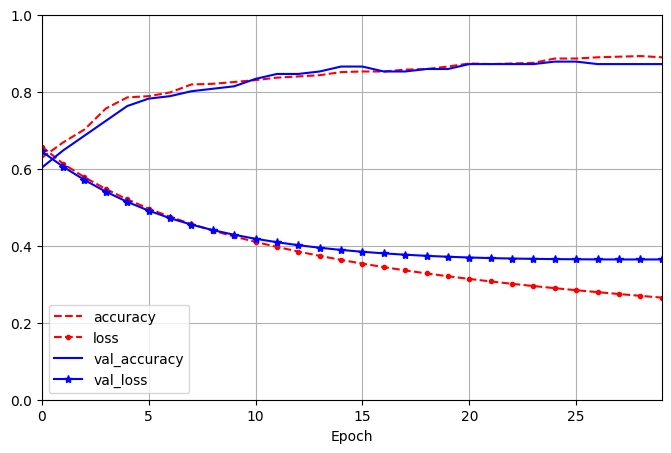

In [102]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

In [103]:
model.evaluate(X_test.values, y_test.values)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8684 - loss: 0.3459 


[0.3800586760044098, 0.8589743375778198]

In [104]:
y_proba = model.predict(X_test.values)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


In [105]:
y_proba[:5]

array([[9.9237794e-01, 7.6220799e-03],
       [9.9765348e-01, 2.3464910e-03],
       [9.9999970e-01, 2.9588162e-07],
       [6.2463832e-01, 3.7536168e-01],
       [9.9990731e-01, 9.2576811e-05]], dtype=float32)

In [106]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1])

In [107]:
classification_metrics(y_test, y_pred)

accuracy score:		0.85897

f1 score:		0.85611
precision score:	0.85407
recall score:		0.85934


## Значимость признаков

In [ ]:
importances = model_cat.feature_importances_

In [ ]:
importances

array([ 3.31752687,  2.17242855,  1.07525735,  1.90821665,  1.887289  ,
       12.22816367,  3.0278678 , 19.8365794 ,  3.03859494,  0.23711742,
        1.02243404,  1.94368337,  0.74525105,  0.63864396,  2.72433303,
        7.45446419,  2.66181116,  1.16247087,  1.92248785,  1.10837606,
        1.89470572,  2.92832972,  1.22604024,  1.05541866,  1.60171281,
        5.76730409,  0.24552993,  1.41070356,  3.66630624,  1.58529892,
        7.36484341,  0.07442895,  1.06638052])

In [ ]:
df.columns

Index(['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay',
       'Alvarado_Score', 'Appendix_on_US', 'Migratory_Pain',
       'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness',
       'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature',
       'WBC_Count', 'Neutrophil_Percentage', 'Neutrophilia', 'RBC_Count',
       'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'Ketones_in_Urine',
       'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool',
       'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness',
       'US_Performed', 'Free_Fluids', 'Diagnosis'],
      dtype='object')

In [ ]:
len(importances), len(df.columns[:-1])

(33, 33)

In [ ]:
dictionary = dict(zip(df.columns[:-1], importances))

In [ ]:
srt_feat = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))
srt_feat

{'Appendix_on_US': 19.836579401187485,
 'Length_of_Stay': 12.228163670425445,
 'WBC_Count': 7.4544641922793895,
 'Ipsilateral_Rebound_Tenderness': 7.36484341377552,
 'CRP': 5.767304090433955,
 'Peritonitis': 3.6663062357355862,
 'Age': 3.3175268744536415,
 'Migratory_Pain': 3.038594943464547,
 'Alvarado_Score': 3.027867803190659,
 'Thrombocyte_Count': 2.9283297220572306,
 'Body_Temperature': 2.724333027204219,
 'Neutrophil_Percentage': 2.661811156665194,
 'BMI': 2.17242854791058,
 'Coughing_Pain': 1.9436833675089382,
 'RBC_Count': 1.9224878497334892,
 'Height': 1.9082166532173215,
 'RDW': 1.8947057212637706,
 'Weight': 1.8872889969369704,
 'WBC_in_Urine': 1.601712813742619,
 'Psoas_Sign': 1.585298924781637,
 'Stool': 1.4107035606386407,
 'Ketones_in_Urine': 1.2260402383825424,
 'Neutrophilia': 1.1624708697729405,
 'Hemoglobin': 1.1083760571502252,
 'Sex': 1.0752573462418236,
 'Free_Fluids': 1.0663805169009897,
 'RBC_in_Urine': 1.0554186559189644,
 'Contralateral_Rebound_Tenderness': 1.

## Выводы

Построены модели классификации:

* Catboost
* RandomForestClassifier
* Support Vector Machine
* GradientBoostingClassifier
* Keras / sparse_categorical_crossentropy

Получены схожие значения метрики (кроме SVM)

Спомощью классификатора Catboost определена значимость признаков:

- Appendix_on_US: 19.84,
- Length_of_Stay: 12.23,
- WBC_Count: 7.45,
- Ipsilateral_Rebound_Tenderness: 7.36,
- CRP: 5.77

